# Model testing

## import modules and merge data

In [1]:

import sys
import pandas as pd              # python package for dataframes
import os                        # used to change directory paths
import matplotlib.pyplot as plt  # python package for plotting
import numpy as np
import seaborn as sns #package for plotting
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from IPython.display import display, HTML  # Make tables pretty
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
#import sklearn.cross_validation.Bootstrap as bootstrap
import scipy
import zipfile
import gzip

#no need to open here
#with gzip.open('\\\\cskma0294\\F\\Evaluations\\JobPath\\WeeklyStatus_flags2018-12-28.gz') as f:
#    df= pd.read_csv(f).iloc[:,1:] # drop 1st column (an artefact of the zipping process)
                            
#df.head()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
path_data = "\\\cskma0294\\F\\Evaluations\\JobPath"
os.chdir(path_data)

#df = pd.read_csv('Dec2015_anonx.csv', parse_dates = ['StartDate', 'EndDate', 'dob'])
# %% [markdown]
# ## Import outcomes dataset and tidy up

# %%
df = pd.read_csv("jp_outcomes.csv")


In [3]:

# Convert floats to ints to make reporting easier
numerics = ["float64"]
for col in df.select_dtypes(include=numerics).columns:
    if df[col].isnull().sum() == 0:
        # print(col)
        df[col] = df[col].astype("int")
# for col in df.columns:
#     print(col)


In [4]:
path_data = "\\\cskma0294\\F\\Evaluations\\JobPath\\Quarterly_status"
os.chdir(path_data)

#df = pd.read_csv('Dec2015_anonx.csv', parse_dates = ['StartDate', 'EndDate', 'dob'])
# %% [markdown]
# ## Import outcomes dataset and tidy up

# %%
df_shares = pd.read_csv("shares_2017.zip")
df2=pd.merge(df, df_shares, on='ppsn', how='left')

In [5]:
# Tidy up T and C columns to make processing easier
periods = []
for i in range(1, 9):
    this_period = 'period_'+str(i)
    df2[this_period] = df2['Group'+str(i)].str[:1]
    periods.append(this_period)

# Eliminate earlier T people from later period C
for i in range(1, 9):
    for j in range(i+1, 9):
        df2['period_'+str(j)].loc[df2['period_'+str(i)] == 'T'] = 0

# %% [markdown]
# ## Look - a group triangle!



C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [7]:

ys=[]
for i in range(1,9):
    this_period = 'period_'+str(i)
    this_y='y_'+str(i)
    df2[this_y] = df2[this_period].replace(['T', 'C', '0'],[1, 0, np.NaN])
    ys.append(this_y)


In [8]:
df2['y_1'].value_counts()


0.0    88767
1.0     5581
Name: y_1, dtype: int64

In [10]:
df2.head()

,Unnamed: 0,id,ppsn,cluster,age,duration_days_0,sex,LM_code_rank_P1,occupation_rank_P1,ada_code_rank_P1,...,period_7,period_8,y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8
0,0,0,0099665M,2,54,6316,1,6,2.0,5,...,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1,1,0206477C,2,59,3964,2,6,5.0,5,...,C,C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2,0202920T,2,59,1285,2,6,7.0,4,...,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,3,0205276K,5,55,1415,2,6,2.0,6,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,0202425J,2,59,2445,2,6,7.0,5,...,C,C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Select features

In [11]:
#features =['sw_pay_mean_1315', 'earn_tot_mean_1315', 'age', 'occupation_rank_P1','Duration Bands', 'cluster', 
#  'family_flag_rank_P1', 'WSW_13_15share', 'Ed_or_Training_13_15share', 'LM_WSW_13_15share']
features =['sw_pay_mean_1315', 
           'earn_tot_mean_1315', 
           'age', 
           'occupation_rank_P1',
          'Duration Bands',
           #'LM_code_rank_P1',
          #'LM_WSW_13_15share',
           #'family_flag_rank_P1',
           #'LM_WSW_13_15share',
           #'hist_lr_0',
           #'total_duration_days',
           # 'Duration Bands',
           #'Empl_13_15share',
            #'Empl_13_15sum',
 'Ed_or_Training_13_15share',
 #'Ed_or_Training_13_15sum',
 'LM_WSW_13_15share',
 #'LM_WSW_13_15sum',
 #'LR_13_15share',
 #'LR_13_15sum',
 'WSW_13_15share',
 #'WSW_13_15sum',
           #'Ed_or_Training_13_15share',
          ]

df = df2[features] # to enforce column order
df['y']=df2['y_1']
#y=['y_1']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [12]:
df['y'].value_counts()

0.0    88767
1.0     5581
Name: y, dtype: int64

In [13]:

df=df.dropna()
list(df)


['sw_pay_mean_1315',
 'earn_tot_mean_1315',
 'age',
 'occupation_rank_P1',
 'Duration Bands',
 'Ed_or_Training_13_15share',
 'LM_WSW_13_15share',
 'WSW_13_15share',
 'y']

In [14]:
y=df['y'].values
X=df.drop('y', axis='columns').values

In [74]:
X.shape

(91352, 8)

## train test split

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=21, stratify=y)

## Testing K-nearest neighbours

In [62]:
knn = KNeighborsClassifier(n_neighbors=3)

In [19]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [20]:
y_pred = knn.predict(X_test)

In [21]:
print(knn.score(X_test, y_test))

0.930762704907


In [22]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[33980   370]
 [ 2160    31]]
             precision    recall  f1-score   support

        0.0       0.94      0.99      0.96     34350
        1.0       0.08      0.01      0.02      2191

avg / total       0.89      0.93      0.91     36541



0.940039955119


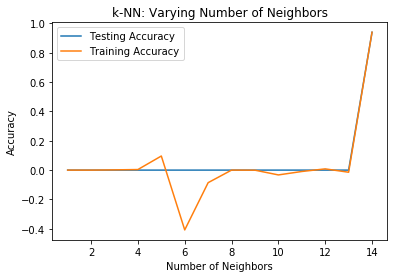

In [64]:
neighbors = np.arange(1, 15)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn =KNeighborsClassifier(n_neighbors=i)

    # Fit the classifier to the training data
knn.fit(X_train, y_train)
   
    #Compute accuracy on the training set
train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
test_accuracy[i] = knn.score(X_test, y_test)
print(test_accuracy[i])    

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

## Testing Logistic regression

In [81]:
logreg = LogisticRegression()

In [82]:
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [83]:
y_pred = logreg.predict(X_test)

##### redirect to save images

In [64]:
path_data = "\\\cskma0294\\F\\Evaluations\\JobPath\\Python\\Analysis\\ModellingTreatment\\Images"
os.chdir(path_data)


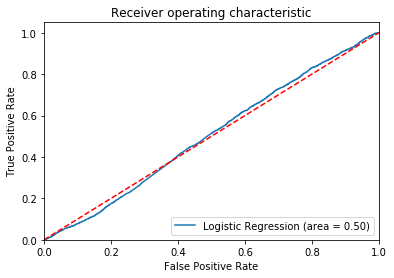

In [84]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()

In [85]:
y_pred_prob = logreg.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred_prob)

0.50400910461694126

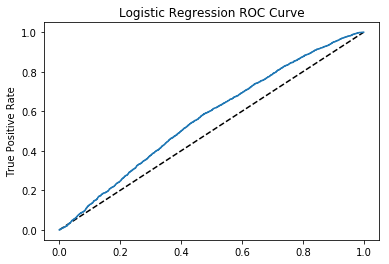

In [17]:




y_pred_prob = logreg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
#plt.xlabel('False Positive Rate’)
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
#plt.savefig("reg2.png", format='png', dpi=100,  bbox_inches='tight')
plt.show();

## Testing Lasso

In [30]:
lasso = Lasso(alpha=0.1, normalize=True)

In [31]:
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)


In [32]:
print(lasso.score(X_test, y_test))

-1.65872870994e-09


Feature selection using lasso

In [33]:
names = df.drop('y', axis=1).columns

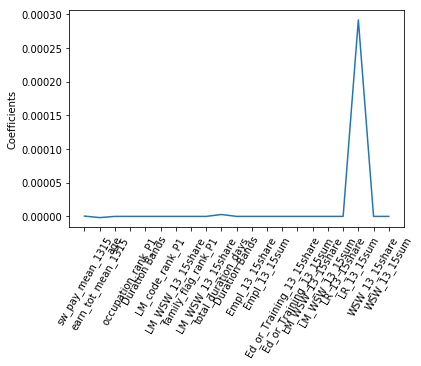

In [34]:
lasso = Lasso(alpha=0.1)
lasso_coef = lasso.fit(X, y).coef_
_ = plt.plot(range(len(names)), lasso_coef)
_ = plt.xticks(range(len(names)), names, rotation=60)
_ = plt.ylabel('Coefficients')
plt.show()

In [36]:
train_score=lasso.score(X_train,y_train)
test_score=lasso.score(X_test,y_test)
coeff_used = np.sum(lasso.coef_!=0)
print ("training score:", train_score )
print ("test score: ", test_score)
print ("number of features used: ", coeff_used)


training score: 0.00388729409025
test score:  0.00351551641266
number of features used:  4


In [42]:
lasso009 = Lasso(alpha=0.9, max_iter=10e5)
lasso009.fit(X_train,y_train)
train_score009=lasso009.score(X_train,y_train)
test_score009=lasso002.score(X_test,y_test)
coeff_used009 = np.sum(lasso009.coef_!=0)
print ("training score for alpha=0.09:", train_score009 )
print ("test score for alpha =0.09: ", test_score009)
print ("number of features used: for alpha =0.09:", coeff_used009)

training score for alpha=0.09: 0.00202130572888
test score for alpha =0.09:  0.00479898670286
number of features used: for alpha =0.09: 3


In [39]:
lasso002 = Lasso(alpha=0.02, max_iter=10e5)
lasso002.fit(X_train,y_train)
train_score002=lasso002.score(X_train,y_train)
test_score002=lasso002.score(X_test,y_test)
coeff_used002 = np.sum(lasso002.coef_!=0)
print ("training score for alpha=0.02:", train_score002 )
print ("test score for alpha =0.02: ", test_score002)
print ("number of features used: for alpha =0.02:", coeff_used002)

training score for alpha=0.02: 0.00550527814745
test score for alpha =0.02:  0.00479898670286
number of features used: for alpha =0.02: 6


In [40]:
lasso00001 = Lasso(alpha=0.0001, max_iter=10e5)
lasso00001.fit(X_train,y_train)
train_score00001=lasso00001.score(X_train,y_train)
test_score00001=lasso00001.score(X_test,y_test)
coeff_used00001 = np.sum(lasso00001.coef_!=0)
print ("training score for alpha=0.0001:", train_score00001 )
print ("test score for alpha =0.0001: ", test_score00001)
print ("number of features used: for alpha =0.0001:", coeff_used00001)


training score for alpha=0.0001: 0.00583970262363
test score for alpha =0.0001:  0.00507264613939
number of features used: for alpha =0.0001: 12


In [41]:
lasso000001 = Lasso(alpha=0.00001, max_iter=10e5)
lasso000001.fit(X_train,y_train)
train_score000001=lasso000001.score(X_train,y_train)
test_score000001=lasso000001.score(X_test,y_test)
coeff_used000001 = np.sum(lasso000001.coef_!=0)
print ("training score for alpha=0.00001:", train_score000001 )
print ("test score for alpha =0.00001: ", test_score000001)
print ("number of features used: for alpha =0.00001:", coeff_used000001)

training score for alpha=0.00001: 0.0058417218196
test score for alpha =0.00001:  0.00506779700771
number of features used: for alpha =0.00001: 14


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


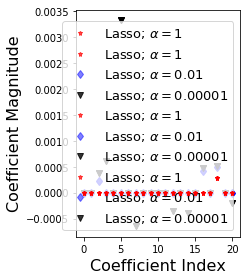

In [46]:






# lr = LinearRegression()
# lr.fit(X_train,y_train)
# lr_train_score=lr.score(X_train,y_train)
# lr_test_score=lr.score(X_test,y_test)
# print "LR training score:", lr_train_score 
# print "LR test score: ", lr_test_score
# plt.subplot(1,2,1)
# plt.plot(lasso.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Lasso; $\alpha = 1$',zorder=7) # alpha here is for transparency
# plt.plot(lasso001.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Lasso; $\alpha = 0.01$') # alpha here is for transparency

#plt.xlabel('Coefficient Index',fontsize=16)
#plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.legend(fontsize=13,loc=4)
plt.subplot(1,2,2)
plt.plot(lasso.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Lasso; $\alpha = 1$',zorder=7) # alpha here is for transparency
plt.plot(lasso002.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Lasso; $\alpha = 0.01$') # alpha here is for transparency
plt.plot(lasso00001.coef_,alpha=0.8,linestyle='none',marker='v',markersize=6,color='black',label=r'Lasso; $\alpha = 0.00001$') # alpha here is for transparency
#plt.plot(lr.coef_,alpha=0.7,linestyle='none',marker='o',markersize=5,color='green',label='Linear Regression',zorder=2)
plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.legend(fontsize=13,loc=4)
plt.tight_layout()
plt.show()


## Testing Random forest

## Hyperparameter tuning

#### For logistic

In [18]:
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}


In [19]:
logreg= LogisticRegression()

logreg_cv = GridSearchCV(logreg, param_grid, cv=5)

logreg_cv.fit(X,y)


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-05,   8.48343e-05,   7.19686e-04,   6.10540e-03,
         5.17947e-02,   4.39397e-01,   3.72759e+00,   3.16228e+01,
         2.68270e+02,   2.27585e+03,   1.93070e+04,   1.63789e+05,
         1.38950e+06,   1.17877e+07,   1.00000e+08])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [20]:
start=datetime.now()

cv_results=cross_val_score(logreg, X, y, cv=9)
print(cv_results)

print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 

print("Best score is {}".format(logreg_cv.best_score_))

print (datetime.now()-start)


[ 0.94000591  0.94000591  0.94000591  0.94000591  0.94000591  0.94
  0.94009262  0.94009262  0.94009262]
Tuned Logistic Regression Parameters: {'C': 1.0000000000000001e-05}
Best score is 0.9400341536036431
0:00:06.389561


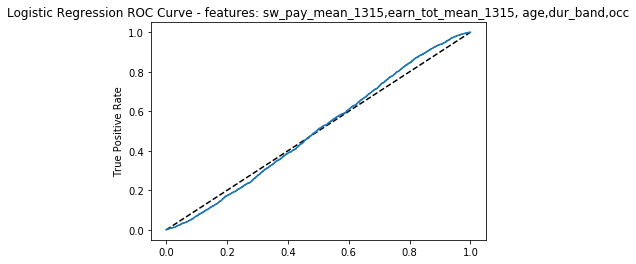

In [21]:

y_pred_prob = logreg_cv.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
#plt.xlabel('False Positive Rate’)
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve - features: sw_pay_mean_1315,earn_tot_mean_1315, age,dur_band,occ')
#plt.savefig("reg2.png", format='png', dpi=100,  bbox_inches='tight')
plt.show();

In [22]:
y_pred_prob = logreg_cv.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred_prob)

0.50280376849318076

#### Hyper - KNN

In [57]:
param_grid = {'n_neighbors': np.arange(1, 14)}

In [58]:
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid, cv=5)

start=datetime.now()
knn_cv.fit(X, y)

print (datetime.now()-start)

0:06:13.601768


In [59]:
print(knn_cv.best_params_)
print(knn_cv.best_score_)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


{'n_neighbors': 12}
0.940034153604
[[34350     0]
 [ 2191     0]]
             precision    recall  f1-score   support

        0.0       0.94      1.00      0.97     34350
        1.0       0.00      0.00      0.00      2191

avg / total       0.88      0.94      0.91     36541



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [75]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Create the hyperparameter grid
l1_space = np.linspace(0, 1, 30)
param_grid = {'l1_ratio': l1_space}


# Instantiate the ElasticNet regressor: elastic_net
elastic_net = ElasticNet()

# Setup the GridSearchCV object: gm_cv
gm_cv = GridSearchCV(elastic_net, param_grid, cv=5)

# Fit it to the training data
gm_cv.fit(X_train, y_train)

# Predict on the test set and compute metrics
y_pred = gm_cv.predict(X_test)
r2 = gm_cv.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print("Tuned ElasticNet l1 ratio: {}".format(gm_cv.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))
print("Tuned ElasticNet MSE: {}".format(mse))


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increa

Tuned ElasticNet l1 ratio: {'l1_ratio': 0.0}
Tuned ElasticNet R squared: 0.005065086889448178
Tuned ElasticNet MSE: 0.056079345097482


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


## Sensitivity

## graphical output reproduced

In [71]:
df['earn_tot_mean_1315'].plot(type=barh bin=100)
plt.show()

SyntaxError: invalid syntax (<ipython-input-71-0272121f4aba>, line 1)

In [74]:
df['Duration Bands'].plot
plt.show()

## Conclusion

  fit a logistic regression model and output predicted probabilities of y

In [78]:
logreg = LogisticRegression(class_weight='balanced')
logreg.fit(X, y)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [79]:
y_pred = logreg.predict(X)
y_pred_prob = logreg.predict_proba(X)[:,1]
print(y_pred_prob)
type(y_pred_prob)

[ 0.55769409  0.58541036  0.58757194 ...,  0.57025876  0.42179012
  0.58768381]


numpy.ndarray

convert the ndarray into a dataframe and add that one column dataframe to the df dataframe

In [90]:
df['Propensity'] = pd.Series(y_pred_prob)


In [91]:
df.shape

(91352, 10)

In [93]:
df['Propensity'].describe()

count    7.600900e+04
mean     4.912774e-01
std      7.807691e-02
min      2.280562e-08
25%      4.655020e-01
50%      5.108584e-01
75%      5.446192e-01
max      5.968601e-01
Name: Propensity, dtype: float64

calculate inverse probability weights - note the separate columns for c and t. Better to do the c calculation conditional on y_1  being 0, and then weight is 1 if y_1 is 1

In [38]:

#if y_1=1 then ipw= 1/0 + (1-1)/(1-0)
#if y_1=0 then ipw= 0/'0' + (1-0)/(1-'0')

#final['iptw_t']=1/0+(1-1)/(1-0)
final['iptw_c']= 0/final['Propensity'] + (1-0)/(1-final['Propensity'])
final['iptw_t']= 1

#final['iptw'] = np.where(final['iptw_c']!=NaN, final['iptw_c'], 'no')


In [96]:
list(df)
df['y'].unique()

array([ 0.,  1.])

 unsuccessful attempt to either show graphically the distribution of scores by y, or groupby y to calculate means

In [128]:
df=df.reset_index()
df=df.rename(columns={'index': 'id'})


In [184]:
df.groupby("y")["Propensity"].unique()

y
0.0    [0.557694086394, 0.585410355448, 0.58757194016...
1.0    [0.497419858823, 0.552419073728, 0.43106114293...
Name: Propensity, dtype: object

In [176]:
# %%
def add_weights(df, period):
    # 1. Create scores
    # Currently done above with global ranks but need to replace

    # 2. Create bins based on scores
    # Create a temporary df for T and C groups
    df_T = df.loc[df[period] == 1].copy()
    df_C = df.loc[df[period] == 0].copy()
        # Split T group into equal sized bins
    
    df_T["bin"], bins = pd.qcut(df_T["Propensity"], 100, retbins=True, labels=False)

    # Put C group into T bins based on T bin edges
    #df_T["bin"]=df_T["bin"].astype('int')
    #print(df_T[df_T["bin"].isna()])
    print(df_T["bin"].isnull().count())
    df_T["bin"]=df_T["bin"].astype('category')
    df_C["bin"] = pd.cut(df_C["Propensity"], bins, labels=range(len(bins) - 1))
    df_C["bin"]=df_C["bin"].cat.add_categories([999])
    df_T["bin"]=df_T["bin"].cat.add_categories([999])
    print(df_C.groupby("bin").count())

    
    #df_C["bin"]=df_C["bin"].fillna(999)
    # Exclude unassigned C group members to eliminate outliers
    df_C = df_C.dropna(subset=["bin"])
    df_C["bin"] = df_C["bin"].astype("int")
    print(f"Size of T dataframe, {df_T.shape}")
    print(df_C.shape)
    print(df.shape)

    # 3. Add weights based on bins
    # Create counts for T and C by bin
    t_bin_counts = pd.Series(df_T.groupby("bin")["Propensity"].count(), name="t_bin_counts")
    c_bin_counts = pd.Series(df_C.groupby("bin")["Propensity"].count(), name="c_bin_counts")
    bin_counts = pd.concat([t_bin_counts, c_bin_counts], axis="columns")

    # Divide T by C to get weights for C group
    bin_counts["abs_weight"] = bin_counts["t_bin_counts"] / bin_counts["c_bin_counts"]
    c_total = df_C.shape[0]
    t_total = df_T.shape[0]
    bin_counts["weight"] = bin_counts["abs_weight"] * c_total / t_total

    # All Ts have weight = 1
    df_T["weight"] = 1
    df_T["abs_weight"] = 1

    # Assign C weights based on weights in bin_counts dataframe
    # Have to reset and then set index to avoid losing it!
    df_C = df_C.reset_index()
    df_C = df_C.merge(bin_counts, how="left", left_on="bin", right_index=True )
    df_C = df_C.set_index("id")

#     # Append T and C dataframes together
    out_df = df_T.append(df_C)
   #out_df = out_df[["weight", "abs_weight", 'bin']]
    
    return out_df

# %%

w_df = add_weights(df, 'y')


5478
     level_0   id  sw_pay_mean_1315  earn_tot_mean_1315  age  \
bin                                                            
0        777  777               777                 777  777   
1        693  693               693                 693  693   
2        613  613               613                 613  613   
3        838  838               838                 838  838   
4        876  876               876                 876  876   
5        655  655               655                 655  655   
6        599  599               599                 599  599   
7        688  688               688                 688  688   
8        927  927               927                 927  927   
9        649  649               649                 649  649   
10       673  673               673                 673  673   
11       770  770               770                 770  770   
12       611  611               611                 611  611   
13       723  723               723

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexes\category.py:138: RuntimeWarning: Values and categories have different dtypes. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  data = Categorical(data, categories=categories, ordered=ordered)


In [143]:
w_df.shape

(76768, 18)

In [ ]:

unique_vals = final['y'].unique()
print(unique_vals)
final['y'].value_counts()

# # Sort the dataframe by target
# # Use a list comprehension to create list of sliced dataframes
targets = [final.loc[final['y'] == val] for val in unique_vals]
for index, group in enumerate(['Control', 'Treatment']):
    subset=final.loc[df['y'] ==index]
    print(subset.shape)
    sns.kdeplot(subset[0], kernel='gau', label = group )
plt.legend()
plt.show()

In [44]:
#final['iptw']short_term = dataframe.loc[dataframe['StartDate'].dt.year == year]

final['iptw'] = np.where(final['iptw_c']!=1, final['iptw_c'], final['iptw_t'])

the code above may have assigned the inverse probability weights to iptw when iptw_c was not 1 and otherwise inserted iptw_t

In [ ]:
#code doesnt' work
print(final['iptw'].groupby(final['periods']).median()          

#### final dataframe has twice as many rows as it should have

In [66]:
final.shape

(182704, 13)

[ 0.  1.]
(85874, 12)
(5478, 12)


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


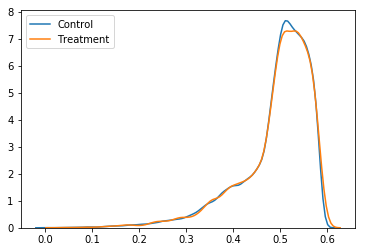

In [147]:

unique_vals = df['y'].unique()
print(unique_vals)
df['y'].value_counts()

# # Sort the dataframe by target
# # Use a list comprehension to create list of sliced dataframes
targets = [df.loc[df['y'] == val] for val in unique_vals]
for index, group in enumerate(['Control', 'Treatment']):
    subset=df.loc[df['y'] ==index]
    print(subset.shape)
    sns.kdeplot(subset['Propensity'], kernel='gau', label = group )
plt.legend()
plt.show()

[ 0.  1.]


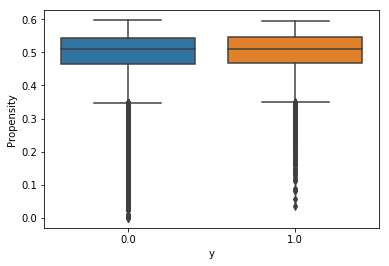

In [152]:

unique_vals = df['y'].unique()
print(unique_vals)
df['y'].value_counts()

sns.boxplot(x="y", y='Propensity', data=df )
plt.legend()
plt.show()

In [185]:

unique_vals = df['y'].unique()
print(unique_vals)
df['y'].value_counts()

sns.scatterplot(x="y", y='Propensity', data=df )
plt.legend()
plt.show()

[ 0.  1.]


AttributeError: module 'seaborn' has no attribute 'scatterplot'

In [ ]:
 #select the important variables and demonstrate how weights (analogous to scaling here) have transformed the data
    #weighted_df['x2'] replaces scaled_df['x2']  
    
#Use StandardScaler
scaler = preprocessing.StandardScaler()
scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df, columns=['x1', 'x2', 'x3'])
# Plot and visualize
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6, 5))

ax1.set_title('Before Scaling')
sns.kdeplot(df['x1'], ax=ax1)
sns.kdeplot(df['x2'], ax=ax1)
sns.kdeplot(df['x3'], ax=ax1)

ax2.set_title('After Standard Scaler')
sns.kdeplot(scaled_df['x1'], ax=ax2)
sns.kdeplot(scaled_df['x2'], ax=ax2)
sns.kdeplot(scaled_df['x3'], ax=ax2)

plt.show()

In [ ]:
 #select the important variables and demonstrate how weights (analogous to scaling above) have transformed the data
    #weighted_df['x2'] replaces scaled_df['x2']  
    


weighted_df = pd.DataFrame(weighted_df, columns=['sw_pay_mean_1315',  'earn_tot_mean_1315', 'age'])
# Plot and visualize
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6, 5))

ax1.set_title('Before weighting')
sns.kdeplot(df['sw_pay_mean_1315'], ax=ax1)
sns.kdeplot(df['earn_tot_mean_1315'], ax=ax1)
sns.kdeplot(df['age'], ax=ax1)

ax2.set_title('After weighting')
sns.kdeplot(scaled_df['sw_pay_mean_1315'], ax=ax2)
sns.kdeplot(scaled_df['earn_tot_mean_1315'], ax=ax2)
sns.kdeplot(scaled_df['age'], ax=ax2)

plt.show()

#### Next, having assigned weights to the dataset, compare 

absolute standardised differences for each of the baseline covariates inthe unweighted sample and in the sample weighted by weights derived from the specification of the propensity score model

 superimpose a line at 10% to indicat the limit of negligible imbalance

    calculate for weighted_df and df for the following variables:

sw_pay_mean_1315',
 'earn_tot_mean_1315',
 'age',
 'occupation_rank_P1',
 'Duration Bands',
 'Ed_or_Training_13_15share',
 'LM_WSW_13_15share',
 'WSW_13_15share',
 'y']
 
 split into four datasets to calculate std dev?

In [73]:
#df.groupby("y").std(ddof=0) 



df.groupby(['y'])['age'].apply(np.std)

df.groupby(['y'])['age'].apply(np.mean)

y
0.0    38.912663
1.0    40.424790
Name: age, dtype: float64

In [ ]:
# is it possible to loop through the columns in the dataframe and calculate a value for smd
# this needs to subtract mean values where y =0 from those where y=1; then add std dev values for both y groups and divide by two

for col in df.columns:
    df['smd']=df.groupby(['y']).apply(np.mean)/df.groupby(['y']).apply(np.std)
            # print(col)
        df[col] = df[col].astype("int")


In [ ]:
scipy.stats.zscore()



[treatment mean (age) - control mean (age)]/sq root (sample variance treatment + sample variance control)/2
for var in vars:
df(var).mean()/statistics.stdev(df(var))

df.loc[:,"age"].std()

sw_pay_mean_1315',
 'earn_tot_mean_1315',
 'age',
 'occupation_rank_P1',
 'Duration Bands',
 'Ed_or_Training_13_15share',
 'LM_WSW_13_15share',
 'WSW_13_15share',
 'y']

calculate mean difference for each variable and std dev, then
df
mean()
statistics.stdev(data)


df.groupby("y").std(ddof=0) 

[ 0.  1.]
(85874, 15)
(5478, 15)


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


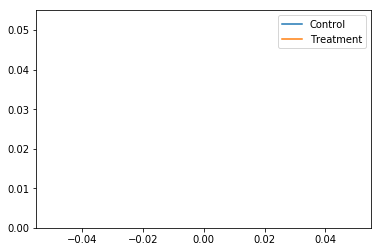

In [27]:

unique_vals = df['y'].unique()
print(unique_vals)
df['y'].value_counts()

# # Sort the dataframe by target
# # Use a list comprehension to create list of sliced dataframes
targets = [df.loc[df['y'] == val] for val in unique_vals]
for index, group in enumerate(['Control', 'Treatment']):
    subset=df.loc[df['y'] ==index]
    print(subset.shape)
    sns.kdeplot(subset['Propensity_LR'], kernel='gau', label = group )
plt.legend()
plt.show()